<a href="https://colab.research.google.com/github/LSSTDESC/TheLastMetric/blob/master/MAFVariationalMutualInformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing Mutual Information Metric for Photoz

## Loading the data

In [1]:
!wget --quiet -O dataset.tar https://drive.google.com/u/0/uc?id=1wZ3UCdZyBKytp5ZS2wk5epOOy7BpYidU&export=download
!tar -xf dataset.tar
!mv for_francois dataset

mv: cannot move 'for_francois' to 'dataset/for_francois': Directory not empty


In [5]:
more dataset/README.txt

In [18]:
from astropy.table import Table
test_cat = Table.read('dataset/baseline_v1.4_10yrs/test.cat', format='ascii')

names_z=('ID', 'z_true', 'z_phot', 'dz_phot', 'NN', 'N_train')
z_cat = Table.read('dataset/baseline_v1.4_10yrs/zphot.cat', 
                       format='ascii', 
                       names=names_z)

names_phot=('ID', 'z_true', 
        'u', 'g', 'r', 'i', 'z', 'y', 
        'err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'err_y', 
        'u-g', 'g-r', 'r-i', 'i-z', 'z-y',
        'err_u-g', 'err_g-r', 'err_r-i', 'err_i-z', 'err_z-y')
phot_cat = Table.read('dataset/baseline_v1.4_10yrs/test.cat', 
                       format='ascii', 
                       names=names_phot)

In [19]:
phot_cat

ID,z_true,u,g,r,i,z,y,err_u,err_g,err_r,err_i,err_z,err_y,u-g,g-r,r-i,i-z,z-y,err_u-g,err_g-r,err_r-i,err_i-z,err_z-y
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
5142370,1.61149,24.121025,0.053106,24.084064,0.021194,24.181071,0.020409,24.123542,0.028792,23.935485,0.044166,23.675364,0.074801,0.036961,0.057179,-0.097007,0.029423,0.057529,0.035292,0.188057,0.052722,0.260121,0.086867
10264978,0.6093701,25.452115,0.146893,25.112487,0.047829,24.362166,0.02385,23.863323,0.024224,23.721593,0.036951,23.736725,0.072242,0.339628,0.154484,0.750321,0.053446,0.498843,0.033995,0.14173,0.044184,-0.015132,0.081144
5218585,1.6459169,24.856706,0.105304,24.879009,0.04023,24.947009,0.038844,24.962829,0.059123,24.902079,0.098635,nan,nan,-0.022303,0.112727,-0.068,0.055922,-0.01582,0.070741,0.06075,0.114998,nan,nan
11234975,0.9162506,nan,nan,25.617169,0.07395,25.367718,0.059883,24.832926,0.052833,24.435467,0.072017,24.543781,0.147004,nan,nan,0.249451,0.095156,0.534792,0.079858,0.397458,0.089318,-0.108313,0.163697
14377082,1.4589336,24.812845,0.099648,24.708982,0.036467,24.659695,0.031157,24.417965,0.036453,23.912078,0.041897,23.50922,0.056821,0.103862,0.106111,0.049287,0.047964,0.24173,0.047954,0.505887,0.055536,0.402858,0.070597
1763375,0.8317933,25.239161,0.167837,25.307067,0.062421,25.126998,0.04635,24.42418,0.036193,24.12068,0.051602,24.131831,0.101631,-0.067906,0.179069,0.180069,0.077747,0.702819,0.058807,0.3035,0.063029,-0.011151,0.113981
7447092,1.6073463,24.761218,0.101785,24.784247,0.037954,24.998465,0.040439,24.650014,0.051406,24.467265,0.07371,24.47997,0.119431,-0.023029,0.10863,-0.214218,0.05546,0.348451,0.065405,0.182749,0.089865,-0.012705,0.140346
10216960,0.37455308,nan,nan,24.9261,0.04246,23.942666,0.016833,23.693673,0.020557,23.573041,0.030371,23.475205,0.059145,nan,nan,0.983433,0.045675,0.248993,0.02657,0.120632,0.036674,0.097836,0.066487
8482528,1.7008493,24.417782,0.077821,24.231526,0.024681,24.613342,0.029089,24.139406,0.030481,23.781078,0.038448,23.650186,0.065284,0.186256,0.081641,-0.381816,0.038149,0.473935,0.042134,0.358329,0.049065,0.130892,0.075765


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['np']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


(array([ 4561., 10575., 11723.,  8702.,  6509.,  4299.,  1959.,  1042.,
          531.,    99.]),
 array([0.01445425, 0.32407044, 0.63368664, 0.94330283, 1.25291903,
        1.56253522, 1.87215142, 2.18176762, 2.49138381, 2.801     ,
        3.1106162 ]),
 <a list of 10 Patch objects>)

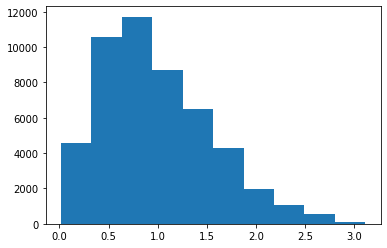

In [22]:
%pylab inline
hist(phot_cat['z_true'])

## Building a Mutual Information Lower Bound

In [11]:
!pip install --quiet flax

     |████████████████████████████████| 92kB 3.6MB/s 


In [13]:
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
import flax 
from flax import nn
import jax
import jax.numpy as np
import numpy as onp

tfb = tfp.bijectors
tfd = tfp.distributions

In [21]:
@nn.module
def NeuralSpline(x, nunits=1, nbins=32):
  def bin_positions(x):
    x = np.reshape(x, [-1, nunits, nbins])
    return nn.activation.softmax(x, axis=-1) *  (2. - nbins * 1e-2) + 1e-2
  
  def slopes(x):
    x = np.reshape(x, [-1, nunits, nbins - 1])
    return nn.activation.softplus(x) + 1e-2

  # Let's have one more non stupid layer
  net = nn.leaky_relu(nn.Dense(x, 128))
  net = nn.BatchNorm(net)
  net = nn.leaky_relu(nn.Dense(net, 128))
  net = nn.BatchNorm(net)

  bin_widths = bin_positions(nn.Dense(net, nunits*nbins))
  bin_heights = bin_positions(nn.Dense(net, nunits*nbins))
  knot_slopes = slopes(nn.Dense(net, nunits*(nbins-1)))

  return tfb.RationalQuadraticSpline(
            bin_widths=bin_widths,
            bin_heights=bin_heights,
            knot_slopes=knot_slopes)

In [38]:
# Now we define some sort of normalizing flow
@nn.module
def ConditionalDensityEstimator(x):
  # Some input processing
  net = nn.BatchNorm(x)
  net = nn.leaky_relu(nn.Dense(x, 128))
  net = nn.BatchNorm(net)
  net = nn.leaky_relu(nn.Dense(net, 128))

  spline1 = NeuralSpline.shared(name='spline1')
  spline2 = NeuralSpline.shared(name='spline2')  

  # And here we define some simple normalizing flow
  bijector_chain = tfb.Chain([
        tfb.Shift(1.0),
        tfb.Tanh(),               
        spline1(x),        
        spline2(x),
        tfb.Scale(0.1)
  ])

  distribution = tfd.TransformedDistribution(tfd.Normal(loc=0., scale=1.),
                                             bijector_chain)
  return distribution

In [39]:
batch_size = 256
def get_batch():
  inds = onp.random.choice(50000, size=batch_size)
  x = np.stack([phot_cat['u'][inds], phot_cat['g'][inds], phot_cat['r'][inds],
                phot_cat['i'][inds]]).astype('float32').T
  y = np.array(phot_cat['z_true'][inds]).astype('float32').reshape((-1,1))
  return {'x':x, 'y':y}

In [44]:
@jax.jit
def train_step(optimizer, batch):
  def loss_fn(model):
    distribution = model(batch['x'])
    loss = - np.mean(distribution.log_prob(batch['y']))
    return loss
  l, grad = jax.value_and_grad(loss_fn)(optimizer.target)

  optimizer = optimizer.apply_gradient(grad)
  return optimizer, l

_, initial_params = ConditionalDensityEstimator.init_by_shape(jax.random.PRNGKey(0),
                                           [((1, 4), np.float32)])

model = flax.nn.Model(ConditionalDensityEstimator, initial_params)

optimizer = flax.optim.Adam(learning_rate=0.001).create(model)

losses = []

In [45]:
for epoch in range(10):
  batch = get_batch()
  optimizer, l = train_step(optimizer, batch)
  losses.append(l)

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5946: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5946: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1601: FutureWarning: jax.numpy redu

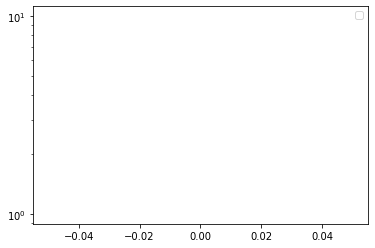

In [46]:
semilogy(np.array(losses[:]))
legend()

In [47]:
losses

[DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32)]